<a href="https://colab.research.google.com/github/WomanX/railsReem2024AM/blob/main/rubyIssueAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook contains a study of the last 500 issues that are related to the rails project: https://github.com/rails/rails/issues.

You will need a github token inside your google colab secrets.
To do this go to https://github.com/settings/tokens/new and generate a token that gives you access to public repos. Then click the little key on the left hand side of this notebook and add a secret named "githubToken" with a value of the token you generated.

Before you run this notebook you have to uncomment the line below, run the cell then restart the kernal. Then once you have restarted the kernal make them comments again.

In [ ]:
 %pip install transformers datasets evaluate

In [ ]:
# Imports and dependancies
# import gc
from datetime import datetime
import pandas as pd
import requests
from huggingface_hub import notebook_login
# import matplotlib


import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
import sentencepiece
from datasets import load_dataset, Dataset, concatenate_datasets
import evaluate
import numpy as np
import torch.nn.functional as nnf
from google.colab import userdata
github_token = userdata.get('githubToken')

In [ ]:
notebook_login()

# Get the Data

In [ ]:
# Get the last 500 issues
repo_url = "https://api.github.com/repos/rails/rails/issues"
headers = {'Authorization': "token " + github_token}
params = {'per_page':'100', 'state' : 'all'}

# Get the first 100 issues from api
response = requests.get(repo_url, headers=headers, params=params)
data = []
data.extend(response.json())

i = 0

# get the next 400
while 'Link' in response.headers and i <= 3:  # check for Link header which indicates pagination info
    links_info = response.headers['Link']

    next_page, last_page = None, None
    if "next" in links_info:
        next_link = links_info.split(",")[0].strip()  # get the link to go to next page
        repo_url = next_link.split(";")[0][1:]   # remove '>' from start of string and split by ';'

    data.extend(requests.get(repo_url, headers=headers, params=params).json())
    i = i+1


In [ ]:
df = pd.DataFrame(data)
# Uncomment line below if you want a CSV of the issues
# df.to_csv("issues.csv",index="False")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   url                       500 non-null    object
 1   repository_url            500 non-null    object
 2   labels_url                500 non-null    object
 3   comments_url              500 non-null    object
 4   events_url                500 non-null    object
 5   html_url                  500 non-null    object
 6   id                        500 non-null    int64 
 7   node_id                   500 non-null    object
 8   number                    500 non-null    int64 
 9   title                     500 non-null    object
 10  user                      500 non-null    object
 11  labels                    500 non-null    object
 12  state                     500 non-null    object
 13  locked                    500 non-null    bool  
 14  assignee                  

# How do the number of issues evolve over time?

<Axes: title={'center': 'Issue Evolution Over Time'}, xlabel='Date', ylabel='# of Issues'>

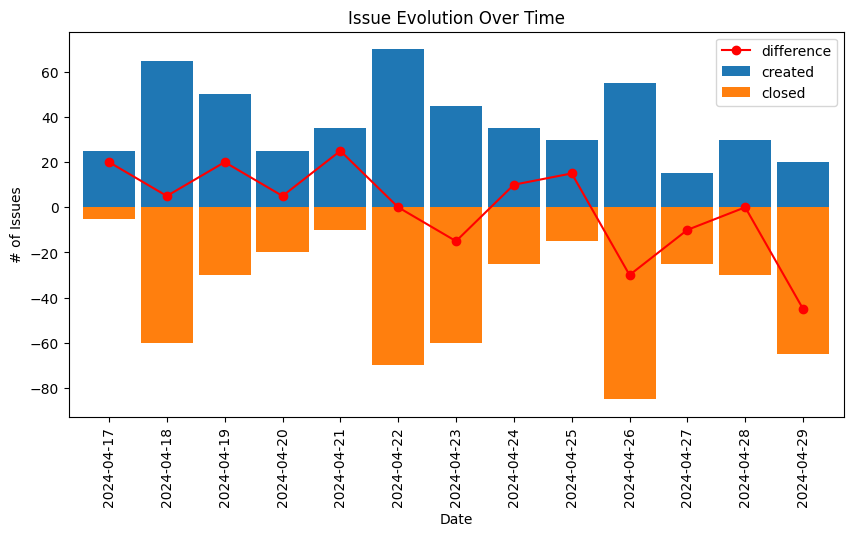

In [ ]:
df['created_at'] = pd.to_datetime(df['created_at']) # Convert string to date time for created at column
df['updated_at'] = pd.to_datetime(df['updated_at']) # Convert string to date time for updated at column
df['closed_at'] = pd.to_datetime(df['updated_at']) # Convert string to date time for closed at column

# Create positive negative barchart data
ccreated = df["created_at"].dt.date.value_counts()
# print(ccreated)
ccreated.name = "created"
cclosed = df["closed_at"].dt.date.value_counts() *-1
# print(cclosed)
cclosed.name = "closed"
merge = pd.concat([ccreated, cclosed], axis=1)
merge.fillna(0, inplace=True)

# Create line chart Data
merge['difference'] = merge['created'] + merge['closed']
merge.reset_index(inplace=True)
merge = merge.rename(columns={"index":"date"})
merge = merge.sort_values(by="date")
merge.reset_index(inplace=True)
merge = merge.drop(["index"],axis=1)
# print(merge)
# Plotting the data

ax = merge[["date","difference"]].plot(linestyle='-', marker='o',color="red")
merge.plot(x="date",y=["created","closed"],
           title="Issue Evolution Over Time",xlabel="Date",
           ylabel="# of Issues",kind='bar',figsize=(10,5),width=0.9,
           stacked=True,ax=ax)

# Are there any periods in which we get more issues?

In [ ]:
m = ccreated.describe().mean()

# Measuring 24 hour periods. Could instead group continuous days together and measure those as periods though that might
# require a more robust defination of "more issues"
print("The mean number of issues created per day is ", m ,". The days were we get more issues created than the mean are")
for t in ccreated.items():
  if t[1] > m:
    print(t[0]," with ", t[1])

The mean number of issues created per day is  32.96348355394875 . The days were we get more issues created than the mean are
2024-04-22  with  70
2024-04-18  with  65
2024-04-26  with  55
2024-04-19  with  50
2024-04-23  with  45
2024-04-24  with  35
2024-04-21  with  35


# Is there anyone who reports more issues than others?

In [ ]:
issue_per_user = df["user"].value_counts()
issues_per_user = issue_per_user.to_frame()
issues_per_user.reset_index(inplace=True)
# print(issue_per_user)
print(issues_per_user['user'][0]['login'], "submits more issues than others with", issues_per_user['count'][0],"issues.")

Earlopain submits more issues than others with 35 issues.


# What is the most popular category (label)?

In [ ]:
def count_occurrences(lst):
    # Create dictionary to store string as key, occurrence as value.
    str_dict = {}

    for s in lst:
        if s not in str_dict:
            str_dict[s] = 1   # If the string is not already a key in dict, add it with count of 1.
        else:
            str_dict[s] += 1    # Else increment its value by one to indicate another occurrence.

    return str_dict

In [ ]:
label_list = []
for issue in df.itertuples():
  for label in issue[12]:
    label_list.append(label['name'])
counts = count_occurrences(label_list)
# print(counts)
print(max(counts, key=lambda k : counts[k]))

activerecord


# Based on the descriptions of the issues alongside the labels you obtained, use any model from HuggingFace to automatically classify the issues into different labels. In other words, the input to your solution is the description of an issue, and the output will be a label for that issue. Report the methodology you followed and the performance of your evaluated model in an adequate way.


## Training a finetuned model on Rails Issues

#### Get more data for training/testing

In [ ]:
# Get the last lots of issues for finetuning
repo_url = "https://api.github.com/repos/rails/rails/issues"
headers = {'Authorization': "token " + github_token}
params = {'per_page':'100', 'state' : 'all'}

# Get the first 100 issues from api
response = requests.get(repo_url, headers=headers, params=params)
bdata = []
bdata.extend(response.json())

i = 0
while 'Link' in response.headers and i <= 100:  # check for Link header which indicates pagination info
    links_info = response.headers['Link']

    next_page, last_page = None, None
    if "next" in links_info:
        next_link = links_info.split(",")[0].strip()  # get the link to go to next page
        repo_url = next_link.split(";")[0][1:]   # remove '>' from start of string and split by ';'

    bdata.extend(requests.get(repo_url, headers=headers, params=params).json())
    i = i+1
bissues_df = pd.DataFrame(bdata)

In [ ]:
bissues_df = bissues_df[['body','labels']]

#change to overall_df at some point
train = bissues_df.sample(frac=0.8,random_state=0)
test = bissues_df.drop(train.index)
train_set = Dataset.from_pandas(train)
test_set = Dataset.from_pandas(test)

#### Training

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-small")

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
# Labels are gotten from the earlier question where I analyze the first 500 issues
label_names = list(counts)
label_names.append("nolabel")
id2label = {}
label2id = {}

i = 0
for l in label_names:
  id2label[i] = l
  label2id[l] = i
  i = i + 1


In [ ]:
def preprocess_function(example):
  if example['body'] == None:
    text = ""
  else:
    text = example['body']

  all_labels = example['labels']
  labels = [0. for i in range(len(label_names))]
  # Creating label vectors
  for label in all_labels:
    if label['name'] in label2id:
      label_id = label2id[label['name']]
      labels[label_id] = 1.
    else:
      label_id = 16
      labels[16] = 1.

  example = tokenizer(text, truncation=True)
  example['labels'] = labels
  return example

In [ ]:
tokenized_issues = train_set.map(preprocess_function)
tokenized_test_set = test_set.map(preprocess_function)

Map:   0%|          | 0/8160 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/2040 [00:00<?, ? examples/s]

In [ ]:
# to make batches of data during training
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
clf_metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])

def sigmoid(x):
   return 1/(1 + np.exp(-x))

def compute_metrics(eval_pred):

   predictions, labels = eval_pred
   predictions = sigmoid(predictions)
   predictions = (predictions > 0.5).astype(int).reshape(-1)
   return clf_metrics.compute(predictions=predictions, references=labels.astype(int).reshape(-1))

In [ ]:
# Creating a multi_label_classification model because there are many times when multiple labels are used in the repo
model = AutoModelForSequenceClassification.from_pretrained(
    "microsoft/deberta-v3-small", num_labels=17, id2label=id2label, label2id=label2id, problem_type = "multi_label_classification"

)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Uncomment out the below cell to train a finetuned model on ruby issues. THIS TAKES A VERY LONG TIME AND REQUIRES STRONG HARDWARE.

In [ ]:
# training_args = TrainingArguments(
#     output_dir="rubyissuefinetune",
#     learning_rate=2e-5,
#     per_device_train_batch_size=1,
#     per_device_eval_batch_size=1,
#     num_train_epochs=2,
#     gradient_checkpointing=True,
#     weight_decay=0.01,
#     evaluation_strategy="epoch",
#     save_strategy="epoch",
#     load_best_model_at_end=True,
# )

# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=tokenized_issues,
#     eval_dataset=tokenized_test_set,
#     tokenizer=tokenizer,
#     data_collator=data_collator,
#     compute_metrics=compute_metrics,
# )

# trainer.train()

Results of training:
```
First Epoch
{'loss': 0.2167, 'grad_norm': 1.6445525884628296, 'learning_rate': 1.9387254901960785e-05, 'epoch': 0.06}
{'loss': 0.1775, 'grad_norm': 2.356264591217041, 'learning_rate': 1.877450980392157e-05, 'epoch': 0.12}
{'loss': 0.1349, 'grad_norm': 0.42108410596847534, 'learning_rate': 1.8161764705882355e-05, 'epoch': 0.18}
{'loss': 0.0758, 'grad_norm': 0.23855403065681458, 'learning_rate': 1.7549019607843138e-05, 'epoch': 0.25}
{'loss': 0.0335, 'grad_norm': 0.07578407973051071, 'learning_rate': 1.693627450980392e-05, 'epoch': 0.31}
{'loss': 0.0224, 'grad_norm': 0.07817607372999191, 'learning_rate': 1.6323529411764708e-05, 'epoch': 0.37}
{'loss': 0.0114, 'grad_norm': 0.03013736940920353, 'learning_rate': 1.571078431372549e-05, 'epoch': 0.43}
{'loss': 0.0054, 'grad_norm': 0.05867712199687958, 'learning_rate': 1.5098039215686276e-05, 'epoch': 0.49}
{'loss': 0.0066, 'grad_norm': 0.014276796020567417, 'learning_rate': 1.448529411764706e-05, 'epoch': 0.55}
{'loss': 0.0025, 'grad_norm': 0.18769985437393188, 'learning_rate': 1.3872549019607844e-05, 'epoch': 0.61}
{'loss': 0.0017, 'grad_norm': 0.009515895508229733, 'learning_rate': 1.3259803921568627e-05, 'epoch': 0.67}
{'loss': 0.0014, 'grad_norm': 0.030435457825660706, 'learning_rate': 1.2647058823529412e-05, 'epoch': 0.74}
{'loss': 0.0012, 'grad_norm': 0.0694856271147728, 'learning_rate': 1.2034313725490197e-05, 'epoch': 0.8}
{'loss': 0.001, 'grad_norm': 0.0034533527214080095, 'learning_rate': 1.142156862745098e-05, 'epoch': 0.86}
{'loss': 0.0007, 'grad_norm': 0.04644719138741493, 'learning_rate': 1.0808823529411765e-05, 'epoch': 0.92}
{'loss': 0.0005, 'grad_norm': 0.00030410944600589573, 'learning_rate': 1.0196078431372549e-05, 'epoch': 0.98}
Second Epoch
{'eval_loss': 0.0002629785449244082, 'eval_accuracy': 1.0, 'eval_f1': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_runtime': 1027.3647, 'eval_samples_per_second': 1.986, 'eval_steps_per_second': 1.986, 'epoch': 1.0}
{'loss': 0.0004, 'grad_norm': 0.0016395667335018516, 'learning_rate': 9.583333333333335e-06, 'epoch': 1.04}
{'loss': 0.0004, 'grad_norm': 0.004406231455504894, 'learning_rate': 8.970588235294119e-06, 'epoch': 1.1}
{'loss': 0.0003, 'grad_norm': 0.00038473313907161355, 'learning_rate': 8.357843137254903e-06, 'epoch': 1.16}
{'loss': 0.0002, 'grad_norm': 0.0058130547404289246, 'learning_rate': 7.745098039215687e-06, 'epoch': 1.23}
{'loss': 0.0002, 'grad_norm': 0.0010857698507606983, 'learning_rate': 7.132352941176472e-06, 'epoch': 1.29}
{'loss': 0.0002, 'grad_norm': 0.008744264952838421, 'learning_rate': 6.519607843137256e-06, 'epoch': 1.35}
{'loss': 0.0003, 'grad_norm': 0.0006399966077879071, 'learning_rate': 5.90686274509804e-06, 'epoch': 1.41}
{'loss': 0.0001, 'grad_norm': 0.00018926741904579103, 'learning_rate': 5.294117647058824e-06, 'epoch': 1.47}
{'loss': 0.0001, 'grad_norm': 0.0009021398145705462, 'learning_rate': 4.681372549019608e-06, 'epoch': 1.53}
{'loss': 0.0001, 'grad_norm': 0.0007254082011058927, 'learning_rate': 4.068627450980392e-06, 'epoch': 1.59}
{'loss': 0.0001, 'grad_norm': 0.0001857579918578267, 'learning_rate': 3.4558823529411766e-06, 'epoch': 1.65}
{'loss': 0.0001, 'grad_norm': 0.0004372298426460475, 'learning_rate': 2.843137254901961e-06, 'epoch': 1.72}
{'loss': 0.0001, 'grad_norm': 0.00015658713527955115, 'learning_rate': 2.2303921568627456e-06, 'epoch': 1.78}
{'loss': 0.0001, 'grad_norm': 0.00028434896375983953, 'learning_rate': 1.6176470588235297e-06, 'epoch': 1.84}
{'loss': 0.0001, 'grad_norm': 0.0003143404028378427, 'learning_rate': 1.0049019607843138e-06, 'epoch': 1.9}
{'loss': 0.0001, 'grad_norm': 0.005150375887751579, 'learning_rate': 3.921568627450981e-07, 'epoch': 1.96}
Result:
{'eval_loss': 2.9273422114783898e-05, 'eval_accuracy': 1.0, 'eval_f1': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_runtime': 1071.8322, 'eval_samples_per_second': 1.903, 'eval_steps_per_second': 1.903, 'epoch': 2.0}
{'train_runtime': 38156.1506, 'train_samples_per_second': 0.428, 'train_steps_per_second': 0.428, 'train_loss': 0.021326195934043248, 'epoch': 2.0}

TrainOutput(global_step=16320, training_loss=0.021326195934043248, metrics={'train_runtime': 38156.1506, 'train_samples_per_second': 0.428, 'train_steps_per_second': 0.428, 'total_flos': 1974512124847692.0, 'train_loss': 0.021326195934043248, 'epoch': 2.0})
```


Uncomment the below line to save that model

In [ ]:
# trainer.save_model("railisfinetune")

## Using the finetuned model

In [ ]:
# I had my mentor train the model on his computer and upload it to huggingface because of internet and elcectricty constraints
tokenizer = AutoTokenizer.from_pretrained("JibreelGG/railisfinetune")
model = AutoModelForSequenceClassification.from_pretrained("JibreelGG/railisfinetune")

tokenizer.json:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.76k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/568M [00:00<?, ?B/s]

In [ ]:
text='''
<!--
Thanks for contributing to Rails!

Please do not make *Draft* pull requests, as they still send
notifications to everyone watching the Rails repo.

Create a pull request when it is ready for review and feedback
from the Rails team :).

If your pull request affects documentation or any non-code
changes, guidelines for those changes are [available
here](https://edgeguides.rubyonrails.org/contributing_to_ruby_on_rails.html#contributing-to-the-rails-documentation)

About this template

The following template aims to help contributors write a good description for their pull requests.
We'd like you to provide a description of the changes in your pull request (i.e. bugs fixed or features added), the motivation behind the changes, and complete the checklist below before opening a pull request.

Feel free to discard it if you need to (e.g. when you just fix a typo). -->

### Motivation / Background

Currently the generated `devcontainer.json` file does not forward the ports required for the project, so you need to manually change it in order to access the project when running via Devcontainer.

This PR adds the required projects for the project.

<!--
Describe why this Pull Request needs to be merged. What bug have you fixed? What feature have you added? Why is it important?
If you are fixing a specific issue, include "Fixes #ISSUE" (replace with the issue number, remove the quotes) and the issue will be linked to this PR.
-->


### Detail

Changed the devcontainer class to include the ports needed for the project and then puts it on the `forwardPorts` attribute on `devcontainer.json`

### Additional information

<!-- Provide additional information such as benchmarks, references to other repositories, or alternative solutions. -->

### Checklist

Before submitting the PR make sure the following are checked:

* [x] This Pull Request is related to one change. Unrelated changes should be opened in separate PRs.
* [x] Commit message has a detailed description of what changed and why. If this PR fixes a related issue include it in the commit message. Ex: `[Fix #issue-number]`
* [x] Tests are added or updated if you fix a bug or add a feature.
* N/A CHANGELOG files are updated for the changed libraries if there is a behavior change or additional feature. Minor bug fixes and documentation changes should not be included.
'''
inputs = tokenizer(text, return_tensors="pt")

In [ ]:
# Custom pipeline so that I can output multiple labels (in the rare cases when more than one label is needed)
with torch.no_grad():
    logits = model(**inputs).logits

prob = nnf.softmax(logits, dim=1)

top_p, top_class = prob.topk(17, dim = 1)

probs = top_p.numpy()[0]
classes = top_class.numpy()[0]
for i in range(17):
    if(probs[i] > 0.000001):
        print("Label: ",model.config.id2label[classes[i]],"| Certainty: ", probs[i])

Label:  railties , Certainty:  1.0


In [ ]:
def issueBodyToLabel(text):
  inputs = tokenizer(text, return_tensors="pt")
  with torch.no_grad():
    logits = model(**inputs).logits

  prob = nnf.softmax(logits, dim=1)

  top_p, top_class = prob.topk(17, dim = 1)

  probs = top_p.numpy()[0]
  classes = top_class.numpy()[0]
  labels = []
  for i in range(17):
      if(probs[i] > 0.000001):
          labels.append({"Label":model.config.id2label[classes[i]],"Certainty": probs[i]})
  return labels

In [ ]:
match_set = []
for row in df[['body','labels']].iterrows():
  issue = row[1]
  match_set.append({"pred":        issueBodyToLabel([issue["body"] if issue["body"] is not None else ''][0]),
                    "user_labels": [x['name'] for x in issue['labels'] if 'name' in x] })


# Interpretaion and analysis of the results (i.e., what can we learn from the findings?)